# Volume 3: Metropolis Algorithm
    <Name> Dallin Stewart
    <Class> ACME 002
    <Date> “Honor is dead. But I'll see what I can do.”

In [44]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from math import sqrt, exp, log
import seaborn as sbn

## Problem 1

Write a function that uses the Metropolis Hastings algorithm to draw from the posterior distribution over the mean $\mu$ and variance $\sigma^2$. Use the given functions and Algorithm 1 to complete the problem.

Your function should return an array of draws, an array of the log probabilities, and an acceptance rate. 
Create plots resembling Figures 1 and 2:
 - Plot the log probabilities of the first 500 samples.
 - Plot the samples for $\mu$ in the order they were drawn, and likewise for $\sigma^2$.
 - Using `seaborn.kdeplot` plot the distribution of all samples for $\mu$, and likewise for $\sigma^2$.

Use $u=20$ for the parameter of the proposal function.
Use the initial state $\mathbf{y}_0=(\mu_0,\sigma^2_0)=(40,10)$.
Take 10,000 samples for both $\mu$ and $\sigma^2$. 

Compare your results with Figures 1 and 2.

In [45]:
def proposal(y, u):
    """The proposal function Q(x,y) = N(x|y,sI)."""
    return stats.multivariate_normal.rvs(mean=y, cov=u*np.eye(len(y)))

In [46]:
def propLogDensity(x, muprior, sig2prior, scores):
    """Calculate the log of the proportional density."""
    logprob = muprior.logpdf(x[0]) + sig2prior.logpdf(x[1])
    logprob += stats.norm.logpdf(scores, loc=x[0], scale=np.sqrt(x[1])).sum()
    return logprob    # ^this is where the scores are used.

In [47]:
def acceptance(x, y, muprior, sig2prior, scores):
    """
    Returns the acceptance probability of moving from y to x.
    """
    return min(0, propLogDensity(x, muprior, sig2prior, scores) - propLogDensity(y, muprior, sig2prior, scores))

In [48]:
def metropolis(y0, u, n_samples, muprior, sig2prior, scores):
    """
    Use the Metropolis algorithm to sample from posterior.
    Parameters:
        y0 ((2,) ndarray): The first entry is mu, the second entry is sigma^2.
        u (float): The standard deviation parameter for the proposal function.
        n_samples (int): The number of samples to generate.
        muprior, sig2prior (scipy.stats distributions): The prior distributions for mu and sigma^2.
        scores ((N,) ndarray): The array of exam scores
    
    Returns:
        draws ((n_samples, 2) ndarray): The MCMC samples.
        logprobs ((n_samples,) ndarray): The values of log f(y) of the samples.
        accept_rate (float): The proportion of accepted proposed samples.
    """
    
    # initialize sampling variables
    y = np.empty((n_samples, 2))
    y[0] = y0
    t = 0
    num_accepted = 0

    while t < n_samples - 1:
        # sample from proposal
        prop = proposal(y[t], u)

        # check acceptance
        a = np.random.uniform(low=0, high=1)
        A = acceptance(prop, y[t], muprior, sig2prior, scores)

        # update sample
        if np.log(a) <= A:
            y[t+1] = prop
            num_accepted += 1
        else:
            y[t+1] = y[t]
        t += 1
    
    # return samples, logprobabilities, and acceptance rate
    logprobs = np.array([propLogDensity(y[i], muprior, sig2prior, scores) for i in range(500)])
    return y, logprobs, num_accepted/(n_samples-1)

In [49]:
# sample
# Load in the data and initialize priors
path = ""
path = "/mnt/c/Users/dalli/source/acme_senior/vl3labs/Metropolis/"
scores = np.load(path + "examscores.npy")

# Prior sigma^2 ~ IG(alpha, beta)
alpha = 3
beta = 50
sig2prior = stats.invgamma(alpha, scale=beta)

# Prior mu ~ N(m, s)
m = 80
s = 4
muprior = stats.norm(loc=m, scale=sqrt(s**2))

# prob 1 parameters
N = 10000
y_init = np.array([40, 10])
u_init = 20

draws, probs, accept_ratio = metropolis(y_init, u_init, N, muprior, sig2prior, scores)

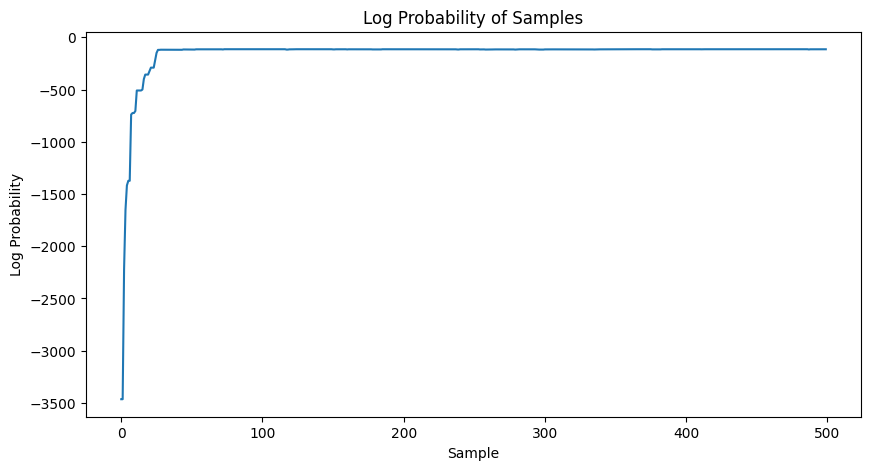

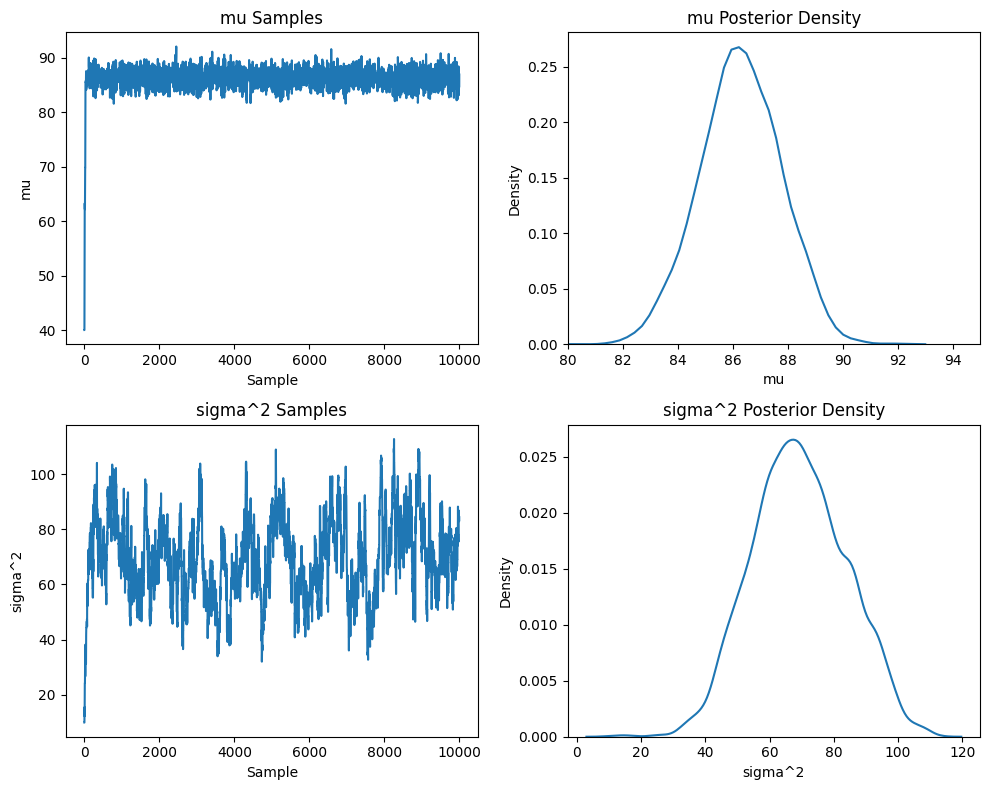

In [50]:
# plot 500 log probabilities
plt.figure(figsize=(10, 5))
plt.plot(probs[:500])
plt.xlabel("Sample")
plt.ylabel("Log Probability")
plt.title("Log Probability of Samples")
plt.show()

# plot u samples
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(draws[:, 0])
plt.xlabel("Sample")
plt.ylabel("mu")
plt.title("mu Samples")

# plot u distribution
plt.subplot(2, 2, 2)
sbn.kdeplot(draws[:, 0])
plt.xlabel("mu")
plt.ylabel("Density")
plt.xlim(80, 95)
plt.title("mu Posterior Density")

# plot sigma^2 samples
plt.subplot(2, 2, 3)
plt.plot(draws[:, 1])
plt.xlabel("Sample")
plt.ylabel("sigma^2")
plt.title("sigma^2 Samples")

# plot sigma^2 distribution
plt.subplot(2, 2, 4)
sbn.kdeplot(draws[:, 1])
plt.xlabel("sigma^2")
plt.ylabel("Density")
plt.title("sigma^2 Posterior Density")
plt.tight_layout()
plt.show()

## Problem 2

Write a function that accepts a spin configuration $\sigma$ for a lattice as a NumPy array.
Compute the energy $H(\sigma)$ of the spin configuration.
Be careful to not double count site pair interactions!

In [51]:
def random_lattice(n):
    """Construct a random spin configuration for an nxn lattice."""
    random_spin = np.zeros((n,n))
    for k in range(n):
        random_spin[k,:] = 2*np.random.binomial(1,.5, n) -1
    return random_spin

In [52]:
def lattice_energy(L):
    """Computer the energy of the spin configuration corresponding to the
    lattice L.
    Parameter:
     L (ndarray): A lattice that we want the spin configuration for.
    
    Returns:
     (float): The spinfiguration of the lattice.
    """
    return -np.sum(L*np.roll(L, 1, axis=0) + L*np.roll(L, 1, axis=1))

## Problem 3

Write a function that accepts an integer $n$ and chooses a pair of indices $(i,j)$ where $0 \le i,j \le n-1$.
Each possible pair should have an equal probability $\frac{1}{n^2}$ of being chosen.

In [53]:
def flip_location(n):
    """Choose a random pair of indices 0 <= i,j <= n-1.
    Parameter:
     n (int): 1/(n^2) probability for each location
     
    Returns:
     (index1, index2) (tuple): the tuple pair of the chosen indices. 
    """
    return (np.random.randint(0, n), np.random.randint(0, n)) 

## Problem 4

Write a function that accepts a spin configuration $\sigma$, its energy $H(\sigma)$, and integer indices $i$ and $j$.
Compute the energy of the new spin configuration $\sigma^*$, which is $\sigma$ but with the spin flipped at the $(i,j)$ th entry of the corresponding lattice.
Do not explicitly construct the new lattice for $\sigma^*$.

In [54]:
def updated_energy(L, L_energy, i, j):
    """Compute the energy of the spin configuration that results
    when the (i,j)th spin of L is flipped.
    
    Parameters:
     L (ndarray): the spin configuration 
     L_energy (float): the energy of the spin configuration.
     i (int): the first index.
     j (int): the second index.
    Returns:
     (float): the energy of the new updated lattice
    """
    n = L.shape[0]
    return L_energy + 2*L[i,j] * (L[(i-1)%n,j] + L[(i+1)%n,j] + L[i,(j-1)%n] + L[i,(j+1)%n])

## Problem 5

Write a function that accepts a float $\beta$ and spin configuration energies $H(\sigma)$ and $H(\sigma^*)$.
Calculate whether or not the new spin configuration $\sigma^*$ should be accepted (return `True` or `False`).

(Hint: np.random.binomial() might be useful function)

In [55]:
def accept(beta, energy_old, energy_new):
    """Accept or reject the new spin configuration.
    
    Parameters:
     beta (float): a quantity inversly proportional to the temperature.
     energy_old (float): the energy of the old lattice.
     energy_new (float): the energy of the updated lattice.
     
    Returns:
     (boolean): whether the new energy should be accepted or not
    """
    if energy_new < energy_old:
        return True
    else:
        return np.random.binomial(1, np.exp(-beta*(energy_new-energy_old)))

## Problem 6

Write a function that accepts a float $\beta>0$ and integers $n$, `n_samples`, and `burn_in`.
Initialize an $n\times n$ lattice for a spin configuration $\sigma$ using `random_lattice()`.
Use the Metropolis algorithm to (potentially) update the lattice `burn_in` times.
1. Use `flip_location()` to choose a site for possibly flipping the spin, thus defining a potential new configuration $\sigma^*$.
2. Use `updated_energy()` to calculate the energy $H(\sigma^*)$ of the proposed configuration.
3. Use `accept()` to accept or reject the proposed configuration. If it is accepted, set $\sigma = \sigma^*$ by flipping the spin at the indicated site.
4. Track $-\beta H(\sigma)$ at each iteration (independent of acceptance).

After the burn-in period, continue the iteration `n_samples` times, also recording every $100$th sample (to prevent memory failure).
Return the samples, the sequence of weighted energies $-\beta H(\sigma)$, and the acceptance rate.

Test your sampler on a $100 \times 100$ grid with $200000$ total iterations, with `n_samples` large enough so that you will keep $50$ samples, for $\beta = 0.2, 0.4, 1$.
Plot the proportional log probabilities, as well as a late sample from each test.


In [74]:
def ising_metropolis(beta, n=100, n_samples=5000, burn_in=195000):
    """Use the Metropolis algorithm to choose new spin configurations.

    Parameters:
        beta (float > 0): Constant inversely proportional to the temperature.
        N (int > 0): The size of the lattice.
        n_samples (int): The number of samples to generate.
        burnin (int): The number of iterations to burn before sampling.

    Returns:
        ((n_samples//100, n,n) ndarray): The sampled spin configurations.
        (n_samples) ndarray: The weighted energies of each configuration.
        (float): The proportion of proposed samples that were accepted.
    """
    # initialize return variables
    samples = np.empty((n_samples//100, n, n))
    energies = np.empty(n_samples + burn_in)
    accept_total = 0

    # initialize spin configuration and energy
    L = random_lattice(n)
    L_energy = lattice_energy(L)

    for k in range(n_samples + burn_in):
        # try a new configuration
        i, j = flip_location(n)
        new_energy = updated_energy(L, L_energy, i, j)
        
        # update spin configuration
        if accept(beta, L_energy, new_energy):
            L[i,j] = -L[i, j]
            L_energy = new_energy
            if k >= burn_in: 
                accept_total += 1
            
        # save samples and energies
        if k >= burn_in and (k - burn_in) % 100 == 0:
            samples[(k - burn_in) // 100] = L.copy()
        energies[k] = -beta * L_energy
    
    return samples, energies, accept_total/n_samples

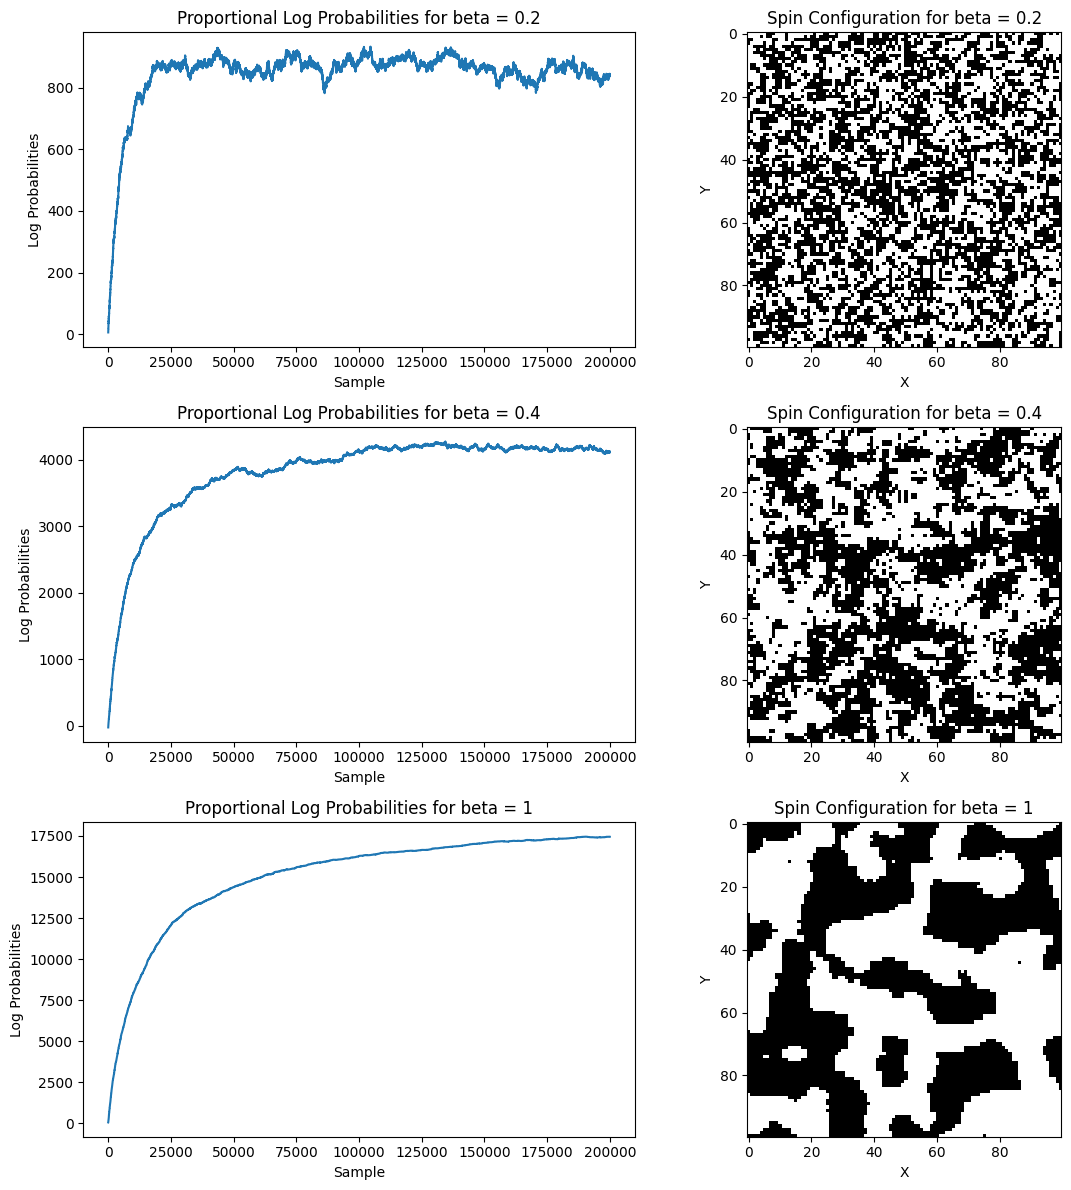

In [76]:
betas = [0.2, 0.4, 1]

plt.figure(figsize=(12, 12))
for i, beta in zip(range(0, 3), betas):
    samples, energies, accept_ratio = ising_metropolis(beta)
    plt.subplot(3, 2, 2*i + 1)
    plt.plot(energies)
    plt.title("Proportional Log Probabilities for beta = " + str(beta))
    plt.xlabel("Sample")
    plt.ylabel("Log Probabilities")

    plt.subplot(3, 2, 2*i + 2)
    plt.imshow(samples[-1], cmap="gray")
    plt.title("Spin Configuration for beta = " + str(beta))
    plt.xlabel("X")
    plt.ylabel("Y")

plt.tight_layout()
plt.show()